In [1]:
import pandas as pd
import numpy as np
from numpy.random import RandomState
from wordcloud import WordCloud

In [2]:
# Load the original dataset
data = pd.read_csv('data/cyberbullying_tweets.csv')


In [3]:
data.shape

(47692, 2)

In [4]:
# Rename columns for simplicity
data = data.rename(
    columns = {'tweet_text': 'text', 'cyberbullying_type':'type'}
)

In [5]:
rng = RandomState(1)
df = data.sample(n = len(data)-100, random_state = rng)


In [6]:
test_data = data.loc[~data.index.isin(df.index)]


# Data exploration 


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47592 entries, 39744 to 33483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    47592 non-null  object
 1   type    47592 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [8]:
df.sample(5)

,text,type
38505,They are just against stupidity from a grade s...,age
25504,I'm very excited to be back on @FLOSSWeekly ne...,other_cyberbullying
11645,Funi: “Vic said some crazy crap about a jelly ...,gender
18086,I'll bet the Muslim church would fire you too....,religion
37173,Couldn’t beat a bit of bully to give you the M...,age


In [9]:
# Check null values
np.sum(df.isnull())

text    0
type    0
dtype: int64

In [10]:
print(df['type'].value_counts())

religion               7982
age                    7966
gender                 7956
ethnicity              7947
not_cyberbullying      7931
other_cyberbullying    7810
Name: type, dtype: int64


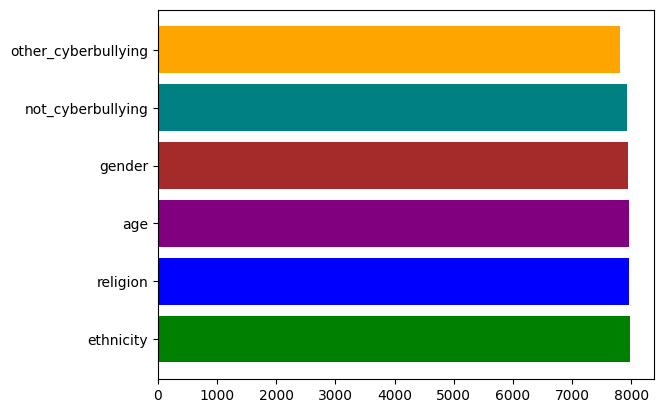

In [11]:
import matplotlib.pyplot as plt
y_axis = df['type'].value_counts()
x_axis = df['type'].unique()

colors = ['green', 'blue', 'purple', 'brown', 'teal', "orange"]
plt.barh(x_axis,y_axis, color = colors)
plt.show()

## DATA PREPROCESSING 


There are not much imbalance among different types remove other_cyberbullying type since it may cause confusion for the models with other cyberbullying class


In [12]:

df = df.drop(index = df[(df['type'] == "other_cyberbullying")].index)

In [13]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()

df['sentiment'] = lenc.fit_transform(df['type'])

In [14]:
df[["type", "sentiment"]].value_counts()

type               sentiment
religion           4            7982
age                0            7966
gender             2            7956
ethnicity          1            7947
not_cyberbullying  3            7931
dtype: int64

In [15]:
sentiments = ["age", "ethnicity", "gender", "not bullying", "religion"]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 39782 entries, 39744 to 33483
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       39782 non-null  object
 1   type       39782 non-null  object
 2   sentiment  39782 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


# Text cleaning to remove noise

In [17]:
import regex as re
import string
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer,PorterStemmer
stop_words = set(stopwords.words('english'))

In [18]:
# remove contractions
def decontract(text):
    return contractions.fix(text)

In [19]:
# remove '#, _' symbol from words 
def clean_hashtags(tweet):
    new_tweet= " ".join(word.strip() for word in re.split('#|_', tweet)) 
    return new_tweet

In [20]:
# remove punctuation, links, stopwords, mentions
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ')
    text = text.lower()
    # remove links and mentions
    text = re.sub(r"(\@|https?\://|(www.))\S+", "", text)
    # remove non utf8/ascii characters
    text = re.sub(r'[^\x00-\x7f]',r'', text) 
    # remove punctuation
    table = str.maketrans('', '',string.punctuation)
    text = text.translate(table)
    # remove stopwords
    text = [
        word for word in text.split() if word not in stop_words
    ]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14)
    # remove multiple sequential spaces
    text = re.sub(r' +', " ", text)
    # remove digits
    text = re.sub(r"\d", "", text)
    return text

In [21]:
# Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

In [22]:
# Lemmatization 
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

In [23]:
# Combine all functions to preprocess
def preprocess(text):
    text = decontract(text)
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = lemmatize(text)
    return text

In [24]:
texts_cleaned = []
for t in df['text']:
    texts_cleaned.append(preprocess(t))


In [25]:
df["text_clean"] = texts_cleaned

In [26]:
df["text_clean"].duplicated().sum()

1107

In [27]:
# remove duplicates
df.drop_duplicates("text_clean", inplace=True)

In [28]:
df["sentiment"].value_counts()

4    7924
0    7844
1    7711
2    7618
3    7578
Name: sentiment, dtype: int64

**After removing duplicates, the value counts per sentiment is shown above. </br>
There is no major imbalance in the preprocessed data**

In [29]:
text_len = []
for text in df["text_clean"]:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

In [30]:
df['text_len'] = text_len

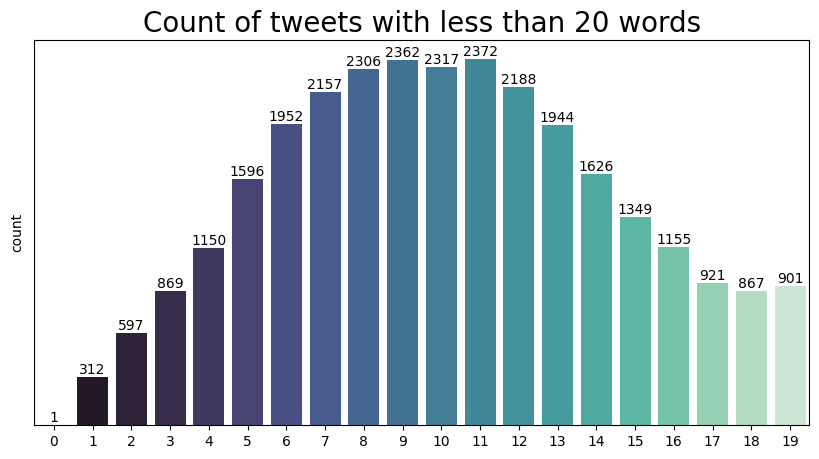

In [31]:
import seaborn as sns
plt.figure(figsize=(10,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<20], palette='mako')
plt.title('Count of tweets with less than 20 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [32]:
df["text_len"].value_counts().sort_values(ascending= False).head()

11    2372
9     2362
10    2317
8     2306
12    2188
Name: text_len, dtype: int64

In [33]:
# checking long tweets
df.sort_values(by=["text_len"], ascending=False)

,text,type,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,1,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,1,fuck obama dumb as nigger bitch ltthis whore s...,152
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,3,researcher push import top antibullying progra...,137
33724,"... I don't feel guilty for killing him, I jus...",age,0,feel guilty killing feel guilty enjoyed tormen...,134
10922,don't make rape jokes!!! don't make gay jokes!...,gender,2,make rape joke make gay joke oh fat joke okay ...,120
...,...,...,...,...,...
4731,@Shjade probs not.,not_cyberbullying,3,probs,1
13098,@Dreysander1 Absolutely.,gender,2,absolutely,1
12302,#IfWomenRuledTheWorld #FeminismIsAwful #femina...,gender,2,feminazi,1
7155,@brianfenton D: php D:,not_cyberbullying,3,php,1


**Removing tweets with less than 4 words and more than 50 words as they can be outliers**

In [34]:
df = df[df['text_len'] > 3]
df = df[df['text_len'] < 50]

In [35]:
df.shape

(36885, 5)

# Use WordCloud to visualize

In [36]:
# plotting word cloud excluding not_cyberbullying
new_df = df
new_df = new_df[new_df['type'] != 'not_cyberbullying']
new_df = new_df['text'].apply(lambda x: "".join(x))

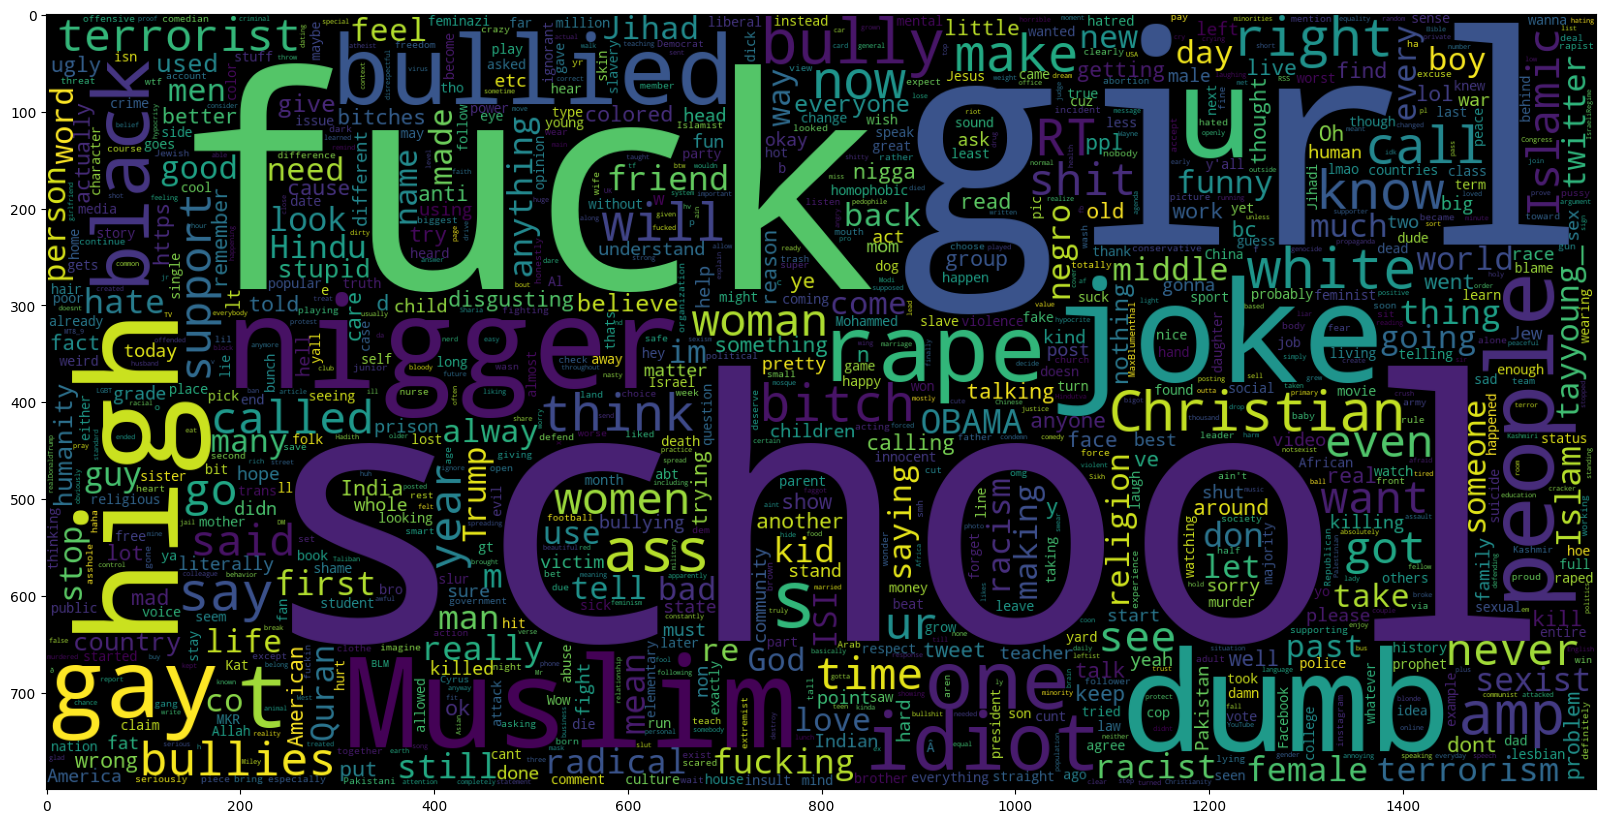

In [37]:
plt.figure(figsize= (20,20))
wc = WordCloud(max_words=1000, width= 1600, height= 800, 
                collocations= False).generate(''.join(new_df))
plt.imshow(wc)

# Vectorize text into numbers

In [38]:
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.metrics import classification_report

cv = CountVectorizer()
X_cv =  cv.fit_transform(df['text_clean'])

tf_transformer = TfidfTransformer(use_idf=True).fit(X_cv)
X_tf = tf_transformer.transform(X_cv)

In [39]:
X_tf

<36885x37969 sparse matrix of type '<class 'numpy.float64'>'
	with 492163 stored elements in Compressed Sparse Row format>

# Split into train and validation data


In [40]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(
    X_tf, df['sentiment'], test_size=0.20, stratify=df['sentiment'], random_state=42
)

In [41]:
y_train.value_counts()

4    6292
0    6231
1    6125
2    5834
3    5026
Name: sentiment, dtype: int64

There are imbalance in cyberbullying types, therefore, we apply SMOTE technique to balance the data

# SMOTE

In [42]:
from imblearn.over_sampling import SMOTE
vc = y_train.value_counts()
while (vc[0] != vc[4]) or (vc[0] !=  vc[2]) or (vc[0] !=  vc[3]) or (vc[0] !=  vc[1]):
    smote = SMOTE(sampling_strategy='minority')
    X_train, y_train = smote.fit_resample(X_train, y_train)
    vc = y_train.value_counts()
vc

1    6292
0    6292
2    6292
3    6292
4    6292
Name: sentiment, dtype: int64

# Create models


In [43]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('Classification Report for Random Forest:\n',classification_report(y_test, rf_pred, target_names=sentiments))

Classification Report for Random Forest:
               precision    recall  f1-score   support

         age       0.98      0.97      0.98      1558
   ethnicity       0.99      0.99      0.99      1531
      gender       0.96      0.86      0.91      1459
not bullying       0.79      0.90      0.84      1256
    religion       0.97      0.97      0.97      1573

    accuracy                           0.94      7377
   macro avg       0.94      0.94      0.94      7377
weighted avg       0.94      0.94      0.94      7377



In [44]:
# Naives Bayes
from sklearn.naive_bayes import MultinomialNB
nb_clf = MultinomialNB()
nb_clf.fit(X_train, y_train)
nb_pred = nb_clf.predict(X_test)
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))


Classification Report for Naive Bayes:
               precision    recall  f1-score   support

         age       0.80      0.98      0.88      1558
   ethnicity       0.91      0.92      0.92      1531
      gender       0.89      0.86      0.87      1459
not bullying       0.84      0.49      0.62      1256
    religion       0.86      0.97      0.91      1573

    accuracy                           0.86      7377
   macro avg       0.86      0.84      0.84      7377
weighted avg       0.86      0.86      0.85      7377



In [45]:
# SVM
from sklearn.svm import SVC
svm_clf = SVC(kernel= 'linear', C = 2).fit(X_train, y_train)
svm_pred = svm_clf.predict(X_test)
print('Classification Report for SVM:\n',classification_report(y_test, svm_pred, target_names=sentiments))


Classification Report for SVM:
               precision    recall  f1-score   support

         age       0.96      0.96      0.96      1558
   ethnicity       0.98      0.97      0.98      1531
      gender       0.94      0.89      0.91      1459
not bullying       0.78      0.84      0.81      1256
    religion       0.96      0.95      0.96      1573

    accuracy                           0.93      7377
   macro avg       0.92      0.92      0.92      7377
weighted avg       0.93      0.93      0.93      7377



## CROSS VALIDATION

In [46]:
from sklearn.model_selection import cross_val_score

RF_cv_score = cross_val_score(rf_clf,X_train, y_train, cv=2)
SVM_cv_score = cross_val_score(svm_clf,X_train, y_train, cv=2)

print('Cross validation score (Random Forest Classifier):', RF_cv_score.mean())
print('Cross validation score (Support Vectors Machine):', SVM_cv_score.mean())



Cross validation score (Random Forest Classifier): 0.9365861411315957
Cross validation score (Support Vectors Machine): 0.9263509218054673


The CV score are similar to the test accuracy; therefore, we did not overfit nor underfit the model

In [47]:
# Create a confusion matrix using heatmap
from sklearn.metrics import confusion_matrix 
def print_confusion_matrix(
    confusion_matrix, class_names, figsize = (8,5), fontsize=10
):

    df = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

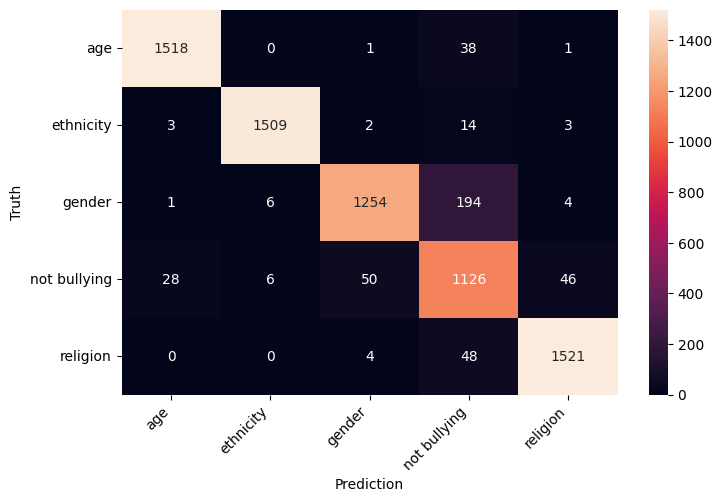

In [48]:
# Random Forest
cm = confusion_matrix(y_test,rf_pred)
print_confusion_matrix(cm,sentiments)

Most number of gender tweets are classified as not_bullying. Perhaps it is due to the oversampling SMOTE technique on gender and not_bullying observations


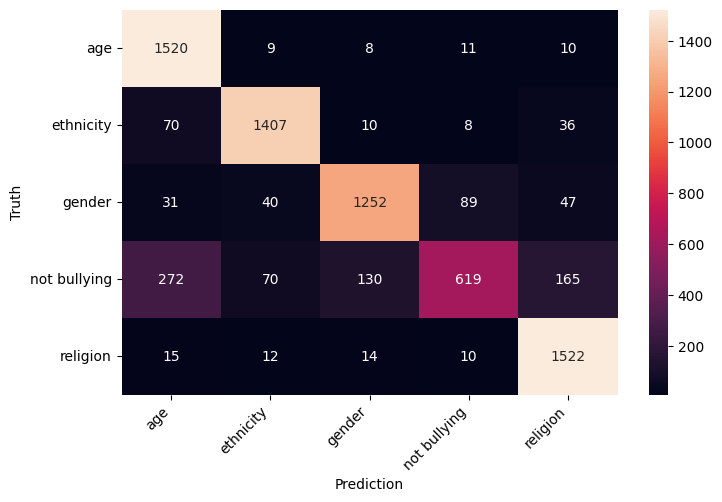

In [49]:
# Naive Bayes
cm = confusion_matrix(y_test,nb_pred)
print_confusion_matrix(cm,sentiments)

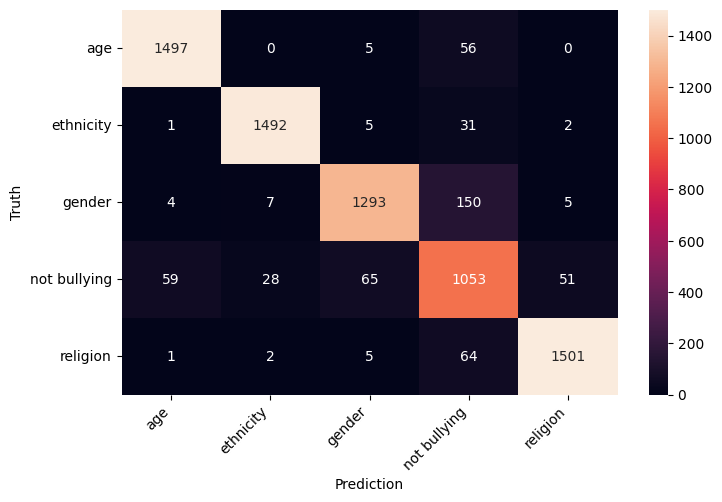

In [50]:
# SVM
cm = confusion_matrix(y_test,svm_pred)
print_confusion_matrix(cm,sentiments)

# Apply to the new test data

Clean test data by dropping 'other_cyberllying' sentiment and apply preprocessing 

In [64]:
test_data = test_data.drop(index = test_data[(test_data['type'] == "other_cyberbullying")].index)
test_data["sentiment"] = lenc.fit_transform(test_data["type"])

In [65]:
test_data.shape

(87, 4)

In [66]:
# Cleaning text test set
import string
test_texts_cleaned = []
for t in test_data.text:
    test_texts_cleaned.append(preprocess(t))


In [67]:
test_cv = cv.transform(test_texts_cleaned)
tf_transformer = TfidfTransformer(use_idf=True).fit(test_cv)
X_tf_test = tf_transformer.transform(test_cv)

In [68]:
# Apply random forest on the new test data 
rf_predictions = rf_clf.predict(X_tf_test)
# RF accuracy
print("Test accuracy:", metrics.accuracy_score(test_data["sentiment"], rf_predictions))

Test accuracy: 0.8850574712643678


sentiments = ["age", "ethnicity", "gender", "not bullying", "religion"]

In [69]:
rf_predictions

array([3, 3, 3, 3, 2, 3, 3, 3, 2, 3, 0, 3, 3, 3, 3, 2, 3, 2, 2, 3, 2, 2,
       2, 3, 2, 2, 3, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [70]:
rf_sentiments = lenc.inverse_transform(rf_predictions)

In [71]:
test_data.drop('sentiment',axis=1, inplace= True)
test_data['rf_prediction'] = rf_sentiments

# Sample prediction of RF on the test data

In [72]:
test_data

,text,type,rf_prediction
15,@yasmimcaci @Bferrarii PAREM DE FAZER BULLYING...,not_cyberbullying,not_cyberbullying
243,YES. I LOVE @lenadunham. http://t.co/ycgTBmmdxb,not_cyberbullying,not_cyberbullying
431,@comattwow @sweharris i have no idea what that...,not_cyberbullying,not_cyberbullying
1046,@ShabanaMir1 I saw Armstrong tell five lies in...,not_cyberbullying,not_cyberbullying
1306,Oh. there goes @wadhwa using his position to s...,not_cyberbullying,gender
...,...,...,...
45413,@InkUp4Lyfe: STINKY PUSSY ONCE AH MONTH BLEEDI...,ethnicity,ethnicity
45571,come say that shit to a NIGGERS face? no? shut...,ethnicity,ethnicity
46467,I can't believe them niggers called me dumb fr...,ethnicity,ethnicity
46857,Fuck you dumb ugly nigger name Wayne Positive ...,ethnicity,ethnicity


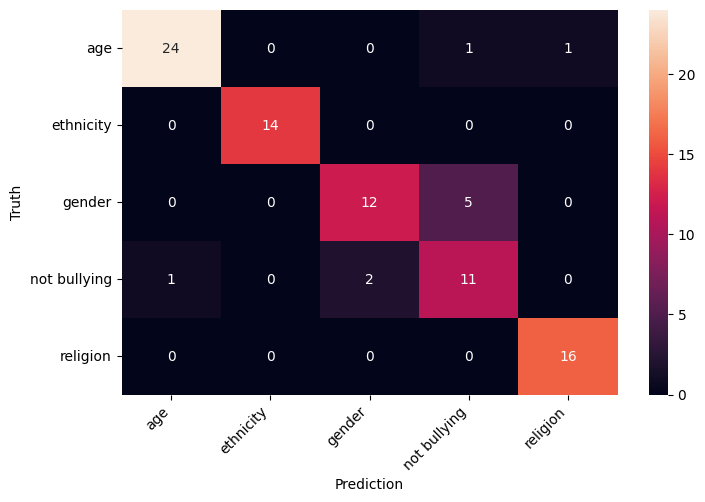

In [73]:
cm = confusion_matrix(test_data["type"],test_data["rf_prediction"])
print_confusion_matrix(cm,sentiments)

# Demonstrate classfication on random tweets

In [74]:
def prep_convert(t):
    text = preprocess(t)
    cv_text = cv.transform([text])
    tf_transformer = TfidfTransformer(use_idf=True).fit(cv_text)
    X_tf_test = tf_transformer.transform(cv_text)
    return X_tf_test

In [75]:
example = "why are you Christian in highschool?"
result = rf_clf.predict(prep_convert(example))
lenc.inverse_transform(result)

array(['religion'], dtype=object)